## Read File

In [1]:
"test"

'test'

In [2]:
import pandas as pd

# CDTX_PATH = '../dataset/train_first/public_train_x_cdtx0001_full_hashed.csv'
# DP_PATH = '../dataset/train_first/public_train_x_dp_full_hashed.csv'
# REMIT_PATH = '../dataset/train_first/public_train_x_remit1_full_hashed.csv'
CUSTINFO_PATH = 'dataset/train_first/public_train_x_custinfo_full_hashed.csv'
PDATE_PATH = 'dataset/train_first/public_x_alert_date.csv'
TDATE_PATH = 'dataset/train_first/train_x_alert_date.csv'
ANSWER_PATH = 'dataset/train_first/train_y_answer.csv'
SAMPLE_PATH = 'dataset/train_first/sample_submission.csv'

# cdtx = pd.read_csv(CDTX_PATH)
# dp = pd.read_csv(DP_PATH)
# remit = pd.read_csv(REMIT_PATH)
cinfo = pd.read_csv(CUSTINFO_PATH)
pdate = pd.read_csv(PDATE_PATH)
tdate = pd.read_csv(TDATE_PATH)
answer = pd.read_csv(ANSWER_PATH)
sample = pd.read_csv(SAMPLE_PATH)

In [3]:
pdate.head()

,alert_key,date
0,352342,365
1,352866,365
2,352696,365
3,352330,365
4,352683,365


In [4]:
# add data label
# pdate > public_x_alert_date is a test dataset
# tdate > train_x_alert_date is a train dataset
pdate.insert(pdate.shape[1], "data_label", ["test"] * pdate.shape[0], True)
tdate.insert(tdate.shape[1], "data_label", ["train"] * tdate.shape[0], True)
date = pd.concat([pdate, tdate], axis=0)
date.head()

,alert_key,date,data_label
0,352342,365,test
1,352866,365,test
2,352696,365,test
3,352330,365,test
4,352683,365,test


In [5]:
# check if the public date and sample submission is the same key
sample[sample['alert_key'].isin(pdate['alert_key'])]

,alert_key,probability
0,357307,0.000017
3,357668,0.000489
4,354443,0.000526
5,361128,0.000887
6,364753,0.001057
...,...,...
3842,357676,0.996705
3844,360534,0.997549
3845,364485,0.997702
3846,363155,0.998987


## Preprocess

In [6]:
import pandas as pd

In [7]:
# Map Date and target to 'cust_info'
cinfo = cinfo.merge(date, on='alert_key', how='left')
cinfo = cinfo.merge(answer, on='alert_key', how='left')

In [8]:
cinfo.head()

,alert_key,cust_id,risk_rank,occupation_code,total_asset,AGE,date,data_label,sar_flag
0,352249,82595ac69158ae08d34156784bdec0d9e2ca5b242b6d2a...,1,19.0,1465816.0,7,365,test,NaN
1,352253,b212d14cb35676926682b2cf849e295d948888f556c07e...,1,2.0,98177.0,2,365,test,NaN
2,352254,e5b0002791c7852644a2730abeaa893cdf14a072ef7812...,1,19.0,2052922.0,7,365,test,NaN
3,352280,74214c478dc6519fbefe4bc31693865bdcd698ab974b64...,3,15.0,201906.0,5,365,test,NaN
4,352282,0340e7611f0d82c3cb87e6194fa14bb2ccf8afbf1b3418...,1,12.0,7450.0,5,365,test,NaN


In [9]:
import copy

# separate
train_cinfo = copy.deepcopy(cinfo)
train_cinfo = train_cinfo[~pd.isna(train_cinfo['sar_flag'])]
train_cinfo.head()

,alert_key,cust_id,risk_rank,occupation_code,total_asset,AGE,date,data_label,sar_flag
1845,171142,a39fea9aec90969fe66a2b2b4d1b86368a2d38e8b8d4bf...,3,12.0,241719.0,3,0,train,0.0
1846,171152,7e42b5dca9b28ee8e5545beb834361e90e6197d176b389...,3,13.0,599497.0,6,0,train,0.0
1847,171177,a6cdf6302aead77112013168c6d546d2df3bcb551956d2...,1,19.0,51160.0,4,0,train,0.0
1848,171178,1a3efa69705f611c7ef2384a715c8142e2ee801cfec9df...,3,9.0,3634343.0,6,0,train,0.0
1849,171180,67f8cbb64dd3d447e992b1b299e0ceed3372188e47c88e...,1,17.0,4076287.0,4,0,train,0.0


In [10]:
mean_encoding_map = {}


def mean_encoding(key):
    key_map = {}
    keys = pd.unique(train_cinfo[key])  #[k for k in pd.unique(X_under[key]) if not (pd.isna(k))]
    for k in keys:
        if pd.isna(k):
            key_map[k] = 0
            continue
        is_sar_num = len((train_cinfo[(train_cinfo['sar_flag'] == 1.0) & (train_cinfo[key] == k)]))
        total_num = len(train_cinfo[train_cinfo[key] == k])
        mean_val = is_sar_num / total_num * 100
        key_map[k] = mean_val
    mean_encoding_map[key] = key_map


mean_encoding('AGE')
mean_encoding('risk_rank')
mean_encoding('date')
mean_encoding('occupation_code')
mean_encoding_map['AGE']

{3: 1.1390728476821192,
 6: 0.5569306930693069,
 4: 0.8374384236453201,
 5: 0.7261724659606656,
 2: 1.2917115177610334,
 9: 0.0,
 1: 1.1363636363636365,
 7: 0.22522522522522523,
 8: 2.3529411764705883,
 10: 0.0,
 0: 0.0}

In [11]:
for k, v in mean_encoding_map.items():
    mean_encoding_val = [0 if (pd.isna(x) or v.get(x) is None) else v[x] for x in cinfo[k]]
    column_name = k + "_encoding"
    cinfo = pd.concat([cinfo, pd.DataFrame({column_name: mean_encoding_val})], axis=1)

cinfo.head()

,alert_key,cust_id,risk_rank,occupation_code,total_asset,AGE,date,data_label,sar_flag,AGE_encoding,risk_rank_encoding,date_encoding,occupation_code_encoding
0,352249,82595ac69158ae08d34156784bdec0d9e2ca5b242b6d2a...,1,19.0,1465816.0,7,365,test,NaN,0.225225,1.293184,0.0,0.941968
1,352253,b212d14cb35676926682b2cf849e295d948888f556c07e...,1,2.0,98177.0,2,365,test,NaN,1.291712,1.293184,0.0,1.282051
2,352254,e5b0002791c7852644a2730abeaa893cdf14a072ef7812...,1,19.0,2052922.0,7,365,test,NaN,0.225225,1.293184,0.0,0.941968
3,352280,74214c478dc6519fbefe4bc31693865bdcd698ab974b64...,3,15.0,201906.0,5,365,test,NaN,0.726172,0.214133,0.0,1.521739
4,352282,0340e7611f0d82c3cb87e6194fa14bb2ccf8afbf1b3418...,1,12.0,7450.0,5,365,test,NaN,0.726172,1.293184,0.0,0.758534


In [12]:
X = cinfo[cinfo['data_label'] == 'train']
len(X)

23906

In [13]:
test = cinfo[cinfo['data_label'] == 'test']
len(test)

1845

In [14]:
test_alert_keys = test['alert_key']
test_alert_keys.head()

0    352249
1    352253
2    352254
3    352280
4    352282
Name: alert_key, dtype: int64

In [15]:
test.head()

,alert_key,cust_id,risk_rank,occupation_code,total_asset,AGE,date,data_label,sar_flag,AGE_encoding,risk_rank_encoding,date_encoding,occupation_code_encoding
0,352249,82595ac69158ae08d34156784bdec0d9e2ca5b242b6d2a...,1,19.0,1465816.0,7,365,test,NaN,0.225225,1.293184,0.0,0.941968
1,352253,b212d14cb35676926682b2cf849e295d948888f556c07e...,1,2.0,98177.0,2,365,test,NaN,1.291712,1.293184,0.0,1.282051
2,352254,e5b0002791c7852644a2730abeaa893cdf14a072ef7812...,1,19.0,2052922.0,7,365,test,NaN,0.225225,1.293184,0.0,0.941968
3,352280,74214c478dc6519fbefe4bc31693865bdcd698ab974b64...,3,15.0,201906.0,5,365,test,NaN,0.726172,0.214133,0.0,1.521739
4,352282,0340e7611f0d82c3cb87e6194fa14bb2ccf8afbf1b3418...,1,12.0,7450.0,5,365,test,NaN,0.726172,1.293184,0.0,0.758534


### Drop confusing customer id
1. get all alert flag where customer id is sar
2. remove all data where cust_id is in sar for non-sar record

In [16]:
sar_cust = X[X['sar_flag'] == 1]
sar_cust.head()

,alert_key,cust_id,risk_rank,occupation_code,total_asset,AGE,date,data_label,sar_flag,AGE_encoding,risk_rank_encoding,date_encoding,occupation_code_encoding
1926,171770,25cf26d9c40bb9f71292b809c4f92018b9bdfe3529c510...,1,17.0,1913895.0,4,0,train,1.0,0.837438,1.293184,1.136364,1.062135
2026,172480,7fde997da7e7a95280460889004bd2f23050bd8953de7e...,3,12.0,8251.0,4,5,train,1.0,0.837438,0.214133,0.657895,0.758534
2281,174298,bf19e3fe441d8dfa31794de3b4c318770ca7da5b4f5973...,1,19.0,186714.0,7,7,train,1.0,0.225225,1.293184,1.204819,0.941968
3443,177788,6400e6bb0fea2dc8410931f6eaf99e9513e4c025f9c9c2...,1,15.0,1744729.0,5,12,train,1.0,0.726172,1.293184,2.380952,1.521739
3479,177960,26eeff4dcdbf9ddb3e2628f8710a1e87b1ea53d37e0331...,1,9.0,238193.0,2,12,train,1.0,1.291712,1.293184,2.380952,0.563014


In [17]:
X = X[~X['cust_id'].isin(sar_cust.cust_id.tolist())]
X.shape

(23019, 13)

In [18]:
X = pd.concat([X, sar_cust])
X.head()

,alert_key,cust_id,risk_rank,occupation_code,total_asset,AGE,date,data_label,sar_flag,AGE_encoding,risk_rank_encoding,date_encoding,occupation_code_encoding
1845,171142,a39fea9aec90969fe66a2b2b4d1b86368a2d38e8b8d4bf...,3,12.0,241719.0,3,0,train,0.0,1.139073,0.214133,1.136364,0.758534
1846,171152,7e42b5dca9b28ee8e5545beb834361e90e6197d176b389...,3,13.0,599497.0,6,0,train,0.0,0.556931,0.214133,1.136364,1.693002
1847,171177,a6cdf6302aead77112013168c6d546d2df3bcb551956d2...,1,19.0,51160.0,4,0,train,0.0,0.837438,1.293184,1.136364,0.941968
1848,171178,1a3efa69705f611c7ef2384a715c8142e2ee801cfec9df...,3,9.0,3634343.0,6,0,train,0.0,0.556931,0.214133,1.136364,0.563014
1849,171180,67f8cbb64dd3d447e992b1b299e0ceed3372188e47c88e...,1,17.0,4076287.0,4,0,train,0.0,0.837438,1.293184,1.136364,1.062135


In [19]:
y = X['sar_flag']
y.shape

(23253,)

## Deal with imbalance problem
-  Over sampling
-  Under sampling

### Training XGBoost - Over sampling

In [20]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

X_smote_prep = copy.deepcopy(X)
X_smote_prep = X_smote_prep.dropna()
X_smote_prep = X_smote_prep.drop(['cust_id', 'data_label'], axis=1)
y_smote_prep = X_smote_prep['sar_flag']
X_smote, y_smote = smote.fit_resample(X_smote_prep, y_smote_prep)
X_smote.shape
X_smote[X_smote['sar_flag'] == 1.0].shape, X_smote[X_smote['sar_flag'] == 0.0].shape

((22903, 11), (22903, 11))

In [21]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.4,
                                                                            random_state=123)
X_train_smote.head()

,alert_key,risk_rank,occupation_code,total_asset,AGE,date,sar_flag,AGE_encoding,risk_rank_encoding,date_encoding,occupation_code_encoding
20012,328400,1,12.000000,500199.000000,2,323,0.0,1.291712,1.293184,0.000000,0.758534
13971,283603,1,13.000000,0.000000,3,244,0.0,1.139073,1.293184,0.943396,1.693002
40819,214438,1,11.447839,228668.534727,3,97,1.0,0.921049,1.293184,4.399997,0.722547
43705,192464,1,9.821295,90.454205,3,43,1.0,1.139073,1.293184,5.324721,1.846196
20733,334830,1,7.000000,0.000000,5,335,0.0,0.726172,1.293184,0.000000,0.000000


In [22]:
import seaborn as sns
from sklearn.metrics import accuracy_score

In [23]:
drop_features_smote = ["alert_key", "sar_flag"]
X_train_smote = X_train_smote.drop(drop_features_smote, axis=1)
X_test_smote = X_test_smote.drop(drop_features_smote, axis=1)

(0.9940511924903127,
 array([[8961,   25],
        [  84, 9253]]))

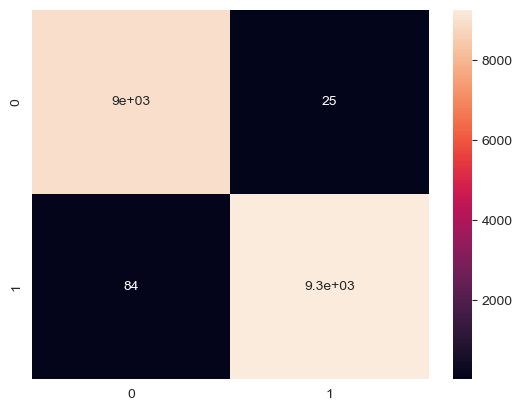

In [24]:
xg_cls_smote = xgb.XGBClassifier()
xg_cls_smote.fit(X_train_smote, y_train_smote)

cls_preds_smote = xg_cls_smote.predict(X_test_smote)

cm_smote = confusion_matrix(y_test_smote, cls_preds_smote)
sns.heatmap(cm_smote, annot=True)

accuracy_score(y_test_smote, cls_preds_smote), cm_smote

### Training XGBoost - Under sampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler()
X_under, y_under = undersample.fit_resample(X, y)

In [41]:
X_under.shape

(468, 13)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2, random_state=123)

### Experiment with encoding
Three scenarios
1. Only original features
2. Only encoding features
3. Original + Encoding features

In [90]:
# original feature
# drop_features = ["alert_key", "cust_id", "data_label", "sar_flag","AGE","date","risk_rank","occupation_code"]

# encoding feature
# drop_features = ["alert_key", "cust_id", "data_label", "sar_flag","AGE_encoding","date_encoding","risk_rank_encoding","occupation_code_encoding"]

# original + encoding feature
drop_features = ["alert_key", "cust_id", "data_label", "sar_flag"]

test = cinfo[cinfo['data_label'] == 'test']
X_train = X_train.drop(drop_features, axis=1)
X_test = X_test.drop(drop_features, axis=1)
test = test.drop(drop_features, axis=1)

KeyError: "['alert_key', 'cust_id', 'data_label', 'sar_flag'] not found in axis"

In [87]:
X_train.head()

,risk_rank,occupation_code,total_asset,AGE,date,AGE_encoding,risk_rank_encoding,date_encoding,occupation_code_encoding
148,3,19.0,1098128.0,3,159,1.139073,0.214133,0.000000,0.941968
131,1,5.0,104.0,2,263,1.291712,1.293184,0.000000,0.554324
437,1,17.0,72355.0,3,245,1.139073,1.293184,1.098901,1.062135
317,3,18.0,867571.0,3,71,1.139073,0.214133,3.896104,0.946970
400,3,18.0,84616.0,3,174,1.139073,0.214133,0.862069,0.946970


In [88]:
xg_cls = xgb.XGBClassifier()
xg_cls.fit(X_train, y_train)

cls_preds = xg_cls.predict(X_test)

The results are as follows:
- `0.7340425531914894` > only original features
- `0.8085106382978723` > only encoding features
- `0.776595744680851` > with encoding and original features

(0.776595744680851,
 array([[40,  7],
        [14, 33]]))

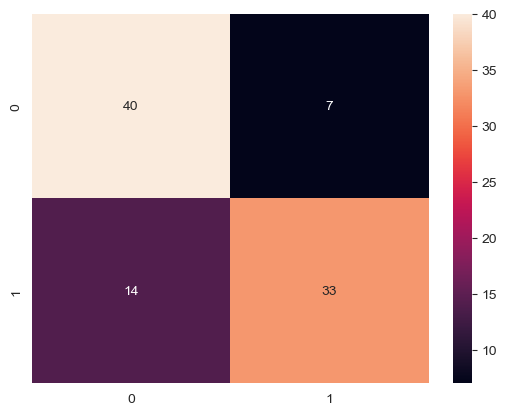

In [91]:
import seaborn as sns
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test, cls_preds)
sns.heatmap(cm, annot=True)
accuracy_score(y_test, cls_preds), cm
#
# 0.7340425531914894 > only original features
# 0.8085106382978723 > only encoding features
# 0.776595744680851 > with encoding and original features


In [32]:
prob_test = [prob[1] for prob in xg_cls.predict_proba(test).tolist()]
prob_test[:10]

[0.4188094735145569,
 0.5452529191970825,
 0.5616642236709595,
 0.001544134458526969,
 0.7702890038490295,
 0.6813327074050903,
 0.06320545822381973,
 0.7882286310195923,
 0.6052678227424622,
 0.002153826877474785]

In [33]:
non_predicted_key = sample[~sample['alert_key'].isin(test_alert_keys)]
non_predicted_key = non_predicted_key.assign(probability=0)
non_predicted_key.shape

(2005, 2)

In [34]:
submission = pd.concat([test_alert_keys, pd.DataFrame({'probability': prob_test})], axis=1)
submission = submission.sort_values(by=['probability'], ascending=False)
submission = pd.concat([submission, non_predicted_key])
submission.shape, submission.head()

((3850, 2),
       alert_key  probability
 461      355759     0.995703
 301      354810     0.995703
 1742     364333     0.994462
 1238     360609     0.994462
 248      354470     0.994462)

In [ ]:
submission.to_csv("submission_xgboost.csv", index=False)

### Aggregation using down-sampling data

In [96]:
local_path = "/Users/kneskung/Code/Datamining/esun_sar_baseline/src/"
CCBA_PATH = local_path + 'train_first/public_train_x_ccba_full_hashed.csv'
ccba = pd.read_csv(CCBA_PATH)

## CCBA description
    cust_id	顧客編號	            Customer                                                    Number
    lupay	上月繳款總額	        Total payment last month	                                Numerical
	byymm	帳務年月	            Accounting year	and                                         Category
	cycam	信用額度	            credits	                                                    Numerical
	usgam	已使用額度	        Quota used	                                                Numerical
	clamt	本月分期預借現金金額	Amount of cash advance in installments this month	        Numerical
	csamt	本月預借現金金額	    Cash advance amount for this month	                        Numerical
	inamt	本月分期消費金額	    Installment spending amount for this month	                Numerical
	cucsm	本月消費金額	        Consumption of this month	                                Numerical
	cucah	本月借現金額	        Borrowed amount this month	                                Numerical

In [169]:
from collections import Counter

# From the observation each value mean month in the form of day
ccba_counter = Counter(ccba.cust_id.tolist())
most_common_cust_ids = [c[0] for c in ccba_counter.most_common()[:]]
ccba_cust_sample = ccba[ccba['cust_id'].isin(most_common_cust_ids)]
ccba_cust_sample

,cust_id,lupay,byymm,cycam,usgam,clamt,csamt,inamt,cucsm,cucah
0,0172056578071e83399216fcd640bdc4de4583149d0fd9...,0.0,0,152628.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0172056578071e83399216fcd640bdc4de4583149d0fd9...,0.0,30,152628.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0172056578071e83399216fcd640bdc4de4583149d0fd9...,0.0,61,152628.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0172056578071e83399216fcd640bdc4de4583149d0fd9...,0.0,91,152628.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0172056578071e83399216fcd640bdc4de4583149d0fd9...,0.0,122,152628.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
59070,ffeb846f2294ec4397f800736dc1e14eb754da5425398d...,0.0,244,781570.0,63952.0,0.0,0.0,0.0,61927.0,0.0
59071,ffeb846f2294ec4397f800736dc1e14eb754da5425398d...,61927.0,275,781570.0,37297.0,0.0,0.0,0.0,37276.0,0.0
59072,ffeb846f2294ec4397f800736dc1e14eb754da5425398d...,37297.0,306,781570.0,45413.0,0.0,0.0,0.0,19766.0,0.0
59073,ffeb846f2294ec4397f800736dc1e14eb754da5425398d...,19766.0,334,781570.0,26360.0,0.0,0.0,1142.0,2568.0,0.0


In [174]:
import numpy as np
from tqdm import tqdm

def cal_ccba_stats(_table, _columns):
    cus_dict = {}
    _cust_ids = pd.unique(_table['cust_id'])
    _byymm = pd.unique(_table['byymm']) # 0 1 2 3 4 5 6 ...

    for cus in tqdm(_cust_ids):
        for col in _columns:
            statistic = {}
            cus_table = _table[_table['cust_id'] == cus]
            # calculate all data
            statistic[col + '_total_mean'] = np.mean(cus_table[col])
            statistic[col + '_total_std'] = np.std(cus_table[col])
            statistic[col + '_total_sum'] = np.sum(cus_table[col])

            # calculate quarter data
            # range 4
            for q in range(4):
                quarter = _byymm[((q) * 3):((q + 1) * 3)] # 0 1 2
                cus_quarter = _table[(_table['cust_id'] == cus) & (_table['byymm'].isin(quarter))]
                statistic[col + '_quarter' + str(q + 1) + '_mean'] = np.mean(cus_quarter[col])
                statistic[col + '_quarter' + str(q + 1) + '_std'] = np.std(cus_quarter[col])
                statistic[col + '_quarter' + str(q + 1) + '_sum'] = np.sum(cus_quarter[col])
            cus_dict[cus] = statistic
    print(("*" * 20) + " Done " + ("*" * 20))
    return cus_dict

aggregated_cust = cal_ccba_stats(ccba_cust_sample,
                                 ['lupay', 'byymm', 'cycam', 'usgam', 'clamt', 'csamt', 'inamt', 'cucsm', 'cucah'])
aggregated_cust

_byymm [  0  30  61  91 122 153 183 214 244 275 306 334 365]


100%|██████████| 4745/4745 [08:20<00:00,  9.47it/s]


******************** Done ********************


{'0172056578071e83399216fcd640bdc4de4583149d0fd936a363abe0724afc1c': {'cucah_total_mean': 0.0,
  'cucah_total_std': 0.0,
  'cucah_total_sum': 0.0,
  'cucah_quarter1_mean': 0.0,
  'cucah_quarter1_std': 0.0,
  'cucah_quarter1_sum': 0.0,
  'cucah_quarter2_mean': 0.0,
  'cucah_quarter2_std': 0.0,
  'cucah_quarter2_sum': 0.0,
  'cucah_quarter3_mean': 0.0,
  'cucah_quarter3_std': 0.0,
  'cucah_quarter3_sum': 0.0,
  'cucah_quarter4_mean': 0.0,
  'cucah_quarter4_std': 0.0,
  'cucah_quarter4_sum': 0.0},
 '0174dff6a8a2038f9966d61d8450e19e3bd751e4051c2ace42799d171742acc1': {'cucah_total_mean': 0.0,
  'cucah_total_std': 0.0,
  'cucah_total_sum': 0.0,
  'cucah_quarter1_mean': 0.0,
  'cucah_quarter1_std': 0.0,
  'cucah_quarter1_sum': 0.0,
  'cucah_quarter2_mean': 0.0,
  'cucah_quarter2_std': 0.0,
  'cucah_quarter2_sum': 0.0,
  'cucah_quarter3_mean': 0.0,
  'cucah_quarter3_std': 0.0,
  'cucah_quarter3_sum': 0.0,
  'cucah_quarter4_mean': 0.0,
  'cucah_quarter4_std': 0.0,
  'cucah_quarter4_sum': 0.0},


In [229]:
aggregated_cust_df = pd.DataFrame.from_dict(aggregated_cust)
aggregated_cust_df = aggregated_cust_df.T.fillna(0)
aggregated_cust_df.index.name = "cust_id"
aggregated_cust_df.to_pickle("aggregated_cust.pkl")
aggregated_cust_df.head()

,cucah_total_mean,cucah_total_std,cucah_total_sum,cucah_quarter1_mean,cucah_quarter1_std,cucah_quarter1_sum,cucah_quarter2_mean,cucah_quarter2_std,cucah_quarter2_sum,cucah_quarter3_mean,cucah_quarter3_std,cucah_quarter3_sum,cucah_quarter4_mean,cucah_quarter4_std,cucah_quarter4_sum
cust_id,,,,,,,,,,,,,,,
0172056578071e83399216fcd640bdc4de4583149d0fd936a363abe0724afc1c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0174dff6a8a2038f9966d61d8450e19e3bd751e4051c2ace42799d171742acc1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01b1735c3dbf0a35c1c989bb45434ce4326b365b73db0612190e56b2858e0184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01c705b457297805c1c08137cb3adb164b8f393c265db2c3aff0a5484a703302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
022bec0a12b56285bf12c49ba1512c0acdbf4176a30d96abeb0e2d4bb2222b99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [230]:
agg_cust = pd.read_pickle('aggregated_cust.pkl')
agg_cust

,cucah_total_mean,cucah_total_std,cucah_total_sum,cucah_quarter1_mean,cucah_quarter1_std,cucah_quarter1_sum,cucah_quarter2_mean,cucah_quarter2_std,cucah_quarter2_sum,cucah_quarter3_mean,cucah_quarter3_std,cucah_quarter3_sum,cucah_quarter4_mean,cucah_quarter4_std,cucah_quarter4_sum
cust_id,,,,,,,,,,,,,,,
0172056578071e83399216fcd640bdc4de4583149d0fd936a363abe0724afc1c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0174dff6a8a2038f9966d61d8450e19e3bd751e4051c2ace42799d171742acc1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01b1735c3dbf0a35c1c989bb45434ce4326b365b73db0612190e56b2858e0184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01c705b457297805c1c08137cb3adb164b8f393c265db2c3aff0a5484a703302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
022bec0a12b56285bf12c49ba1512c0acdbf4176a30d96abeb0e2d4bb2222b99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffa5bcc6f88df5c33e809da4daa54de0031803f37d8f114b0ce2a70519099edc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ffae7fef923c78298cd647a3d573e48cc1404b07ac794a63f436399ceca4ed9d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ffdbc1a5135cb6feddf7355e5656abf6973f21639c7b9b9c8a23f77a194369c9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [231]:
# cinfo = cinfo.merge(answer, on='alert_key', how='left')
X_aggreated_ccba = X.merge(agg_cust, on='cust_id', how='inner')
X_aggreated_ccba

,alert_key,cust_id,risk_rank,occupation_code,total_asset,AGE,date,data_label,sar_flag,AGE_encoding,...,cucah_quarter1_sum,cucah_quarter2_mean,cucah_quarter2_std,cucah_quarter2_sum,cucah_quarter3_mean,cucah_quarter3_std,cucah_quarter3_sum,cucah_quarter4_mean,cucah_quarter4_std,cucah_quarter4_sum
0,171142,a39fea9aec90969fe66a2b2b4d1b86368a2d38e8b8d4bf...,3,12.0,241719.0,3,0,train,0.0,1.139073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,171960,a39fea9aec90969fe66a2b2b4d1b86368a2d38e8b8d4bf...,3,12.0,241719.0,3,5,train,0.0,1.139073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,174802,a39fea9aec90969fe66a2b2b4d1b86368a2d38e8b8d4bf...,3,12.0,241719.0,3,8,train,0.0,1.139073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,176470,a39fea9aec90969fe66a2b2b4d1b86368a2d38e8b8d4bf...,3,12.0,241719.0,3,11,train,0.0,1.139073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,178700,a39fea9aec90969fe66a2b2b4d1b86368a2d38e8b8d4bf...,3,12.0,241719.0,3,13,train,0.0,1.139073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16522,312295,43b1b81d9c666b34cc6bd0c097d129f84ec5ca5714ed69...,1,12.0,1443936.0,4,273,train,1.0,0.837438,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16523,313558,123b9e193e4ebef652be6e48276b35a2981b66f8bfb2bb...,1,12.0,3555871.0,3,291,train,1.0,1.139073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16524,316664,bcf5dc9d464a660377f39ffdf2388cc68859d04448c372...,2,13.0,3702179.0,4,292,train,1.0,0.837438,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16525,346021,9efb72c106f786e5a99a8c2b245864c831cf008dd2e9ee...,1,13.0,310.0,3,351,train,1.0,1.139073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [232]:
y_aggregated = X_aggreated_ccba['sar_flag']
y_aggregated

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
16522    1.0
16523    1.0
16524    1.0
16525    1.0
16526    1.0
Name: sar_flag, Length: 16527, dtype: float64

In [234]:
X_aggreated_ccba

,alert_key,cust_id,risk_rank,occupation_code,total_asset,AGE,date,data_label,sar_flag,AGE_encoding,...,cucah_quarter1_sum,cucah_quarter2_mean,cucah_quarter2_std,cucah_quarter2_sum,cucah_quarter3_mean,cucah_quarter3_std,cucah_quarter3_sum,cucah_quarter4_mean,cucah_quarter4_std,cucah_quarter4_sum
0,171142,a39fea9aec90969fe66a2b2b4d1b86368a2d38e8b8d4bf...,3,12.0,241719.0,3,0,train,0.0,1.139073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,171960,a39fea9aec90969fe66a2b2b4d1b86368a2d38e8b8d4bf...,3,12.0,241719.0,3,5,train,0.0,1.139073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,174802,a39fea9aec90969fe66a2b2b4d1b86368a2d38e8b8d4bf...,3,12.0,241719.0,3,8,train,0.0,1.139073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,176470,a39fea9aec90969fe66a2b2b4d1b86368a2d38e8b8d4bf...,3,12.0,241719.0,3,11,train,0.0,1.139073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,178700,a39fea9aec90969fe66a2b2b4d1b86368a2d38e8b8d4bf...,3,12.0,241719.0,3,13,train,0.0,1.139073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16522,312295,43b1b81d9c666b34cc6bd0c097d129f84ec5ca5714ed69...,1,12.0,1443936.0,4,273,train,1.0,0.837438,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16523,313558,123b9e193e4ebef652be6e48276b35a2981b66f8bfb2bb...,1,12.0,3555871.0,3,291,train,1.0,1.139073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16524,316664,bcf5dc9d464a660377f39ffdf2388cc68859d04448c372...,2,13.0,3702179.0,4,292,train,1.0,0.837438,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16525,346021,9efb72c106f786e5a99a8c2b245864c831cf008dd2e9ee...,1,13.0,310.0,3,351,train,1.0,1.139073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [240]:
drop_features_aggregate = ['alert_key', 'cust_id', 'data_label']
X_aggregated_resampling = copy.deepcopy(X_aggreated_ccba)
X_aggregated_resampling = X_aggregated_resampling.drop(drop_features_aggregate, axis=1)
X_aggregated_resampling = X_aggregated_resampling.dropna()

y_aggregated_resampling = X_aggregated_resampling['sar_flag']
X_aggregated_resampling = X_aggregated_resampling.drop(['sar_flag'], axis=1)
X_aggregated_resampling, y_aggregated_resampling = smote.fit_resample(X_aggregated_resampling, y_aggregated_resampling)

In [244]:
X_train_agg, X_test_agg, y_train_agg, y_test_agg = train_test_split(X_aggregated_resampling, y_aggregated_resampling, test_size=0.2, random_state=123)

In [245]:
xg_cls = xgb.XGBClassifier()
xg_cls.fit(X_train_agg, y_train_agg)

cls_preds = xg_cls.predict(X_test_agg)

(0.9938763012859767,
 array([[3232,    5],
        [  35, 3260]]))

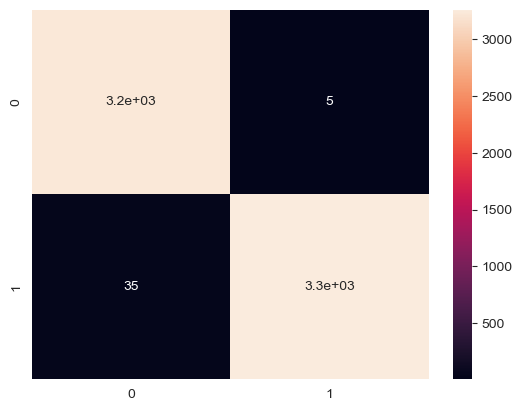

In [246]:
cm = confusion_matrix(y_test_agg, cls_preds)
sns.heatmap(cm, annot=True)
accuracy_score(y_test_agg, cls_preds), cm